# Comparing expression of confirmed substrate-specific transporter genes  in *Ruegeria pomeroyi* DSS-3 digital microbe

This workbook uses several data files obtained from the anvi'o interactive interface. 
These include gene call annotation and coverage files, as well as a file containing the number of total reads mapped. 

The digital microbe can be accessed using this command in the directory where the files are stored: 
`anvi-interactive -c R_POM_DSS3-contigs.db -p PROFILE-VER_01.db`

Once in the interactive interface, create a bin with the genes of interest:
* Here, a confirmed transporters bin was created by searching for genes confirmed in Schroer et al. 2023 (using SPO ID numbers) and appending them to the bin

This bin was saved to a new bin collection. Then, a static summary page was generated (with the `init-gene-coverages` button checked). This static summary page contains the gene call annotation and coverage files for each bin generated.

The bins will contain many more genes than those specifically required (since they contain larger splits), so we will subset them in dataframes here to the genes we want to inspect.

In [1]:
#import necessary packages
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#create dataframes to work with from each text file using pandas
transpo_gene_calls = pd.read_csv("./data/transpo_gene_splits.txt",sep='\t')
transpo_gene_covs = pd.read_csv("./data/transpo_gene_covs.txt",sep='\t')
read_totals_by_sample = pd.read_csv("./data/total_reads.txt",sep='\t')

In [3]:
#visualize the dataframe to be sure it worked and to find the right data
transpo_gene_calls

,gene_callers_id,contig,start,stop,direction,TN_MUTANT_AVAILABLE,TN_MUTANT_AVAILABLE (ACCESSION),SPO_ID,SPO_ID (ACCESSION),COG20_PATHWAY,...,COG20_CATEGORY (ACCESSION),Pfam,Pfam (ACCESSION),COG20_FUNCTION,COG20_FUNCTION (ACCESSION),Gene_ID,Gene_ID (ACCESSION),KOfam,KOfam (ACCESSION),dna_sequence
0,183,chromosome,200810,202328,r,Plate 7 Well A7; Plate 11 Well N13,SPO0184,None,SPO0184,NaN,...,R,Tripartite tricarboxylate transporter TctA family,PF01970.16,TctA family transporter (PUBMED:14499931),COG3333,TctA channel protein,tctA,putative tricarboxylic transport membrane protein,K07793,ATGCTCGAAGGACTGATGATCGGGCTGGGAACGGCCTTTTCGCTCA...
1,184,chromosome,202329,202956,r,Plate 3 Well N5; Plate 11 Well L22,SPO0185,None,SPO0185,NaN,...,NaN,Tripartite tricarboxylate transporter TctB family,PF07331.11,NaN,NaN,"TctB smaller channel protein, 4 transmembrane ...",tctB,putative tricarboxylic transport membrane protein,K07794,GTGACTTCAGCCAGAGGCGTCAAGGTTAACATACTCTTTCCTCTTG...
2,185,chromosome,203120,204098,r,NaN,NaN,None,SPO0186,NaN,...,C,Tripartite tricarboxylate transporter family r...,PF03401.14,"Tripartite-type tricarboxylate transporter, ex...",COG3181,TctC solute-binding protein; tripartate tricar...,tctC,putative tricarboxylic transport membrane protein,K07795,ATGAAAACGAACCTGACCCGCCGGGTCATGATGGCCGCCGCGTCGG...
3,186,chromosome,204207,204873,f,Plate 7 Well F7,SPO0187,None,SPO0187,NaN,...,T!!!K,Response regulator receiver domain,PF00072.24,"DNA-binding response regulator, OmpR family, c...",COG0745,TctD DNA-binding response regulator; tripartat...,tctD,NaN,NaN,ATGCGGTTCCTGTTGGTCGAAGACAATCAGAGTCTGGCTTCGGCCA...
4,187,chromosome,204869,206255,f,Plate 4 Well B1; Plate 14 Well B9,SPO0188,None,SPO0188,NaN,...,T,Two-component sensor kinase N-terminal,PF08521.10,Signal transduction histidine kinase (BaeS) (P...,COG0642,two-component sensor protein,SPO0188,"two-component system, OmpR family, sensor hist...",K07649,ATGAGCGACCGGTTGCGCTCCAGCGGGTCGATCCGGCGCCGGTTGA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,3556,chromosome,3683530,3684619,f,Plate 3 Well O17,SPO3479,None,SPO3479,NaN,...,C,FAD binding domain,PF01565.23,FAD/FMN-containing lactate dehydrogenase/glyco...,COG0277,"glycolate oxidase, GlcE subunit",glcE,glycolate oxidase FAD binding subunit,K11472,ATGCTGAGACCAGAAAGCGAGGCCGAACTGGCCCAGATCGTGGCCG...
372,3557,chromosome,3684622,3685945,f,NaN,NaN,None,SPO3480,NaN,...,C,Cysteine-rich domain,PF02754.16,"Fe-S cluster-containing oxidoreductase, includ...",COG0247,"glycolate oxidase, iron-sulfur subunit",glcF,glycolate oxidase iron-sulfur subunit,K11473,ATGCAGACGAATTTCACCGCCGAACAGCTGACCGATCCCGGTATCC...
373,3558,chromosome,3686004,3687207,r,Plate 5 Well D16,SPO3481,None,SPO3481,NaN,...,G,Uncharacterised MFS-type transporter YbfB,PF06779.14,"Predicted arabinose efflux permease AraJ, MFS ...",COG2814,hypothetical protein,SPO3481,NaN,NaN,TTGCGACATGTCTCTGCATCTATCGGTCACGCGATGACATTGTCGG...
374,3559,chromosome,3687289,3688195,f,Plate 5 Well E8; Plate 12 Well O17,SPO3482,None,SPO3482,NaN,...,O,Trypsin,PF00089.26,V8-like Glu-specific endopeptidase (eMpr),COG3591,trypsin domain protein,SPO3482,protease YdgD [EC:3.4.21.-],K04775,TTGCGCATATCCGCCAAGAAGCCCCGACCACGCCCCATTTTCGCCC...


In [4]:
#subset transporter genes using the list of SPOs (IDs) from Schroer et al. 2023
#I'm going to cheat just a little and paste them in here as a list; each line contains gene components for a single transporter
transpo_genes_list = ['SPO0184','SPO0185','SPO0186',
                 'SPO0376','SPO0377','SPO0378','SPO0379',
                 'SPO0591','SPO0592','SPO0593',
                 'SPO0608','SPO0609','SPO0610','SPO0611','SPO0612',
                 'SPO0674','SPO0675','SPO0676',
                 'SPO0861','SPO0862','SPO0863',
                 'SPO1087',
                 'SPO1145','SPO1146','SPO1147',
                 'SPO1548','SPO1549','SPO1550',
                 'SPO1835','SPO1836','SPO1837','SPO1838','SPO1839',
                 'SPO2356','SPO2357','SPO2358',
                 'SPO2441','SPO2442','SPO2443',
                 'SPO2571','SPO2572','SPO2573',
                 'SPO2626','SPO2627','SPO2628',
                 'SPO2995','SPO2996','SPO2997','SPO2998',
                 'SPO3040','SPO3041','SPO3042','SPO3043',
                 'SPO3186',
                 'SPO3466','SPO3467','SPO3468','SPO3469',
                 'SPO1810']

#fix a column header to make the following apply function work (no spaces!)
transpo_gene_calls.rename(columns={'SPO_ID (ACCESSION)':'SPO'},inplace=True)
#the mask is a boolean array identifying rows in the gene call df that contain the genes we want
mask = transpo_gene_calls.SPO.apply(lambda x: any(gene for gene in transpo_genes_list if gene in x))
#apply the boolean array to the gene call df to get our subset
transpo_genes_df = transpo_gene_calls[mask]
#this method catches a slight error, some SPOs have a B version, we want to discard those
transpo_genes_df = transpo_genes_df[~transpo_genes_df.SPO.str.contains('_B')]
#we have to do all of this because we want specific genes from a list that do not have a consistent name
transpo_genes_df

,gene_callers_id,contig,start,stop,direction,TN_MUTANT_AVAILABLE,TN_MUTANT_AVAILABLE (ACCESSION),SPO_ID,SPO,COG20_PATHWAY,...,COG20_CATEGORY (ACCESSION),Pfam,Pfam (ACCESSION),COG20_FUNCTION,COG20_FUNCTION (ACCESSION),Gene_ID,Gene_ID (ACCESSION),KOfam,KOfam (ACCESSION),dna_sequence
0,183,chromosome,200810,202328,r,Plate 7 Well A7; Plate 11 Well N13,SPO0184,None,SPO0184,NaN,...,R,Tripartite tricarboxylate transporter TctA family,PF01970.16,TctA family transporter (PUBMED:14499931),COG3333,TctA channel protein,tctA,putative tricarboxylic transport membrane protein,K07793,ATGCTCGAAGGACTGATGATCGGGCTGGGAACGGCCTTTTCGCTCA...
1,184,chromosome,202329,202956,r,Plate 3 Well N5; Plate 11 Well L22,SPO0185,None,SPO0185,NaN,...,NaN,Tripartite tricarboxylate transporter TctB family,PF07331.11,NaN,NaN,"TctB smaller channel protein, 4 transmembrane ...",tctB,putative tricarboxylic transport membrane protein,K07794,GTGACTTCAGCCAGAGGCGTCAAGGTTAACATACTCTTTCCTCTTG...
2,185,chromosome,203120,204098,r,NaN,NaN,None,SPO0186,NaN,...,C,Tripartite tricarboxylate transporter family r...,PF03401.14,"Tripartite-type tricarboxylate transporter, ex...",COG3181,TctC solute-binding protein; tripartate tricar...,tctC,putative tricarboxylic transport membrane protein,K07795,ATGAAAACGAACCTGACCCGCCGGGTCATGATGGCCGCCGCGTCGG...
28,381,chromosome,390859,391828,r,Plate 2 Well F2; Plate 5 Well D2,SPO0376,None,SPO0376,NaN,...,F,Branched-chain amino acid transport system / p...,PF02653.16,"ABC-type guanosine uptake system NupNOPQ, perm...",COG1079,"sugar ABC transporter, permease protein",SPO0376,general nucleoside transport system permease p...,K23536,GTGATGGATTTCCTGACGATCATCCAGGTACTCGACTCGACGATCC...
29,382,chromosome,391824,392919,r,Plate 4 Well E22; Plate 6 Well A14; Plate 9 We...,SPO0377,None,SPO0377,NaN,...,F,Branched-chain amino acid transport system / p...,PF02653.16,"ABC-type guanosine uptake system NupNOPQ, perm...",COG4603,"sugar ABC transporter, permease protein",SPO0377,general nucleoside transport system permease p...,K23535,ATGGACAAGATGCCCAAATGGGCCGATGTGGTGCTGATCCCGCTGA...
30,383,chromosome,392918,394448,r,Plate 1 Well H8; Plate 13 Well M22,SPO0378,None,SPO0378,NaN,...,F,ABC transporter,PF00005.27,"ABC-type guanosine uptake system NupNOPQ, ATPa...",COG3845,"sugar ABC transporter, ATP-binding protein",SPO0378,general nucleoside transport system ATP-bindin...,K23537,ATGACCGTCCCCGCCATCGAGCTCAAAGGGATTTCCAAATCCTTTG...
31,384,chromosome,394571,395570,r,Plate 6 Well L9; Plate 12 Well K11,SPO0379,None,SPO0379,NaN,...,T,ABC transporter substrate-binding protein PnrA...,PF02608.14,"Lipoprotein Med, regulator of KinD/Spo0A, PBP1...",COG1744,"sugar ABC transporter, periplasmic sugar-bindi...",SPO0379,basic membrane protein A and related proteins,K07335,ATGACCCTGATGAAATCCCTGATGGGAGCCGCCGCCGCGATGGCGC...
46,601,chromosome,609871,611017,f,NaN,NaN,None,SPO0591,NaN,...,G,Bacterial extracellular solute-binding protein...,PF03480.13,"TRAP-type C4-dicarboxylate transport system, p...",COG1638,Dihydroxypropanesulfonate (DHPS) TRAP transporter,hpsK,TRAP-type transport system periplasmic protein,K21395,ATGAAAGACGACCGGACCGGACTTGCGTCCGCGACACGCCGCAACT...
47,602,chromosome,611096,611639,f,Plate 6 Well C10,SPO0592,None,SPO0592,NaN,...,G,Tripartite ATP-independent periplasmic transpo...,PF04290.12,"TRAP-type C4-dicarboxylate transport system, s...",COG3090,Dihydroxypropanesulfonate (DHPS) TRAP transporter,hpsL,TRAP-type transport system small permease protein,K21394,ATGCCCCTCGCCCGGAGGGAGGGACACGTGACCCCTATCCTGAATG...
48,603,chromosome,611649,612978,f,Plate 1 Well O5; Plate 9 Well B3,SPO0593,None,SPO0593,NaN,...,G,Tripartite ATP-independent periplasmic transpo...,PF06808.12,"TRAP-type C4-dicarboxylate transport system, l...",COG1593,Dihydroxypropanesulfonate (DHPS) TRAP transporter,hpsM,"C4-dicarboxylate transporter, DctM subunit",K11690,ATGCTTTGGAATACCCTCAATCAGACGGTTGAACTGGGCTGGGATT...


In [5]:
#Want to add some details to move from IDs vs IDs to transporter annotations vs experiments
#dictionary for mapping substrates to gene numbers
transpo_genes_dict = {'SPO0184':'citrate; SPO0184','SPO0185':'citrate; SPO0185','SPO0186':'citrate; SPO0186',
                      'SPO0376':'thymidine; SPO0376','SPO0377':'thymidine; SPO0377','SPO0378':'thymidine; SPO0378','SPO0379':'thymidine; SPO0379',
                      'SPO0591':'DHPS; SPO0591','SPO0592':'DHPS; SPO0592','SPO0593':'DHPS; SPO0593',
                      'SPO0608':'glycerol; SPO0608','SPO0609':'glycerol; SPO0609','SPO0610':'glycerol; SPO0610','SPO0611':'glycerol; SPO0611','SPO0612':'glycerol; SPO0612',
                      'SPO0674':'taurine; SPO0674','SPO0675':'taurine; SPO0675','SPO0676':'taurine; SPO0676',
                      'SPO0861':'glucose/xylose; SPO0861','SPO0862':'glucose/xylose; SPO0862','SPO0863':'glucose/xylose; SPO0863',
                      'SPO1087':'choline; SPO1087',
                      'SPO1145':'ectoine; SPO1145','SPO1146':'ectoine; SPO1146','SPO1147':'ectoine; SPO1147',
                      'SPO1548':'TMAO; SPO1548','SPO1549':'TMAO; SPO1549','SPO1550':'TMAO; SPO1550',
                      'SPO1835':'glcNac; SPO1835','SPO1836':'glcNac; SPO1836','SPO1837':'glcNac; SPO1837','SPO1838':'glcNac; SPO1838','SPO1839':'glcNac; SPO1839',
                      'SPO2356':'isethionate; SPO2356','SPO2357':'isethionate; SPO2357','SPO2358':'isethionate; SPO2358',
                      'SPO2441':'DMSP; SPO2441','SPO2442':'DMSP; SPO2442','SPO2443':'DMSP; SPO2443',
                      'SPO2571':'3-hydroxybutyrate; SPO2571','SPO2572':'3-hydroxybutyrate; SPO2572','SPO2573':'3-hydroxybutyrate; SPO2573',
                      'SPO2626':'fumarate/malate/succinate; SPO2626','SPO2627':'fumarate/malate/succinate; SPO2627','SPO2628':'fumarate/malate/succinate; SPO2628',
                      'SPO2995':'carnitine; SPO2995','SPO2996':'carnitine; SPO2996','SPO2997':'carnitine; SPO2997','SPO2998':'carnitine; SPO2998',
                      'SPO3040':'cysteate; SPO3040','SPO3041':'cysteate; SPO3041','SPO3042':'cysteate; SPO3042','SPO3043':'cysteate; SPO3043',
                      'SPO3186':'DMSP; SPO3186',
                      'SPO3466':'spermidine/cadaverine/putrescine; SPO3466','SPO3467':'spermidine/cadaverine/putrescine; SPO3467','SPO3468':'spermidine/cadaverine/putrescine; SPO3468','SPO3469':'spermidine/cadaverine/putrescine; SPO3469',
                      'SPO1810':'acetate; SPO1810'}


#dictionary for mapping sample IDs to study
transcriptome_studies_dict = {
    'SRR1632877':'Durham et al. 2017; Co-culture, replicate A',
    'SRR1619676':'Durham et al. 2017; Co-culture, replicate B',
    'SRR1619677':'Durham et al. 2017; Co-culture, replicate C',
    'SRR1619678':'Durham et al. 2017; Co-culture, replicate D',
    'SRR1619679':'Durham et al. 2017; Mono-culture, replicate A',
    'SRR1632878':'Durham et al. 2017; Mono-culture, replicate B',
    'SRR15670093':'Olofsson et al. 2022; Bacteria_Day0_1; MO19',
    'SRR15670092':'Olofsson et al. 2022; Bacteria_Day0_2; MO20',
    'SRR15670086':'Olofsson et al. 2022; Bacteria_Day15_1; MO28',
    'SRR15670085':'Olofsson et al. 2022; Bacteria_Day15_2; MO29',
    'SRR15670084':'Olofsson et al. 2022; Bacteria_Day15_3; MO30',
    'SRR15670083':'Olofsson et al. 2022; Bacteria_Day20_1; MO31',
    'SRR15670082':'Olofsson et al. 2022; Bacteria_Day20_2; MO32',
    'SRR15670081':'Olofsson et al. 2022; Bacteria_Day20_3; MO33',
    'SRR15670090':'Olofsson et al. 2022; Bacteria_Day3_1; MO22',
    'SRR15670089':'Olofsson et al. 2022; Bacteria_Day3_2; MO23',
    'SRR15670088':'Olofsson et al. 2022; Bacteria_Day3_3; MO24',
    'SRR15670087':'Olofsson et al. 2022; Bacteria_Day8_1; MO26',
    'SRR5680828':'Landa et al. 2019; T4, replicate 1',
    'SRR5680829':'Landa et al. 2019; T1, replicate 1',
    'SRR5680835':'Landa et al. 2019; T1, replicate 2',
    'SRR5680830':'Landa et al. 2019; T2, replicate 1',
    'SRR5680836':'Landa et al. 2019; T2, replicate 2',
    'SRR5680827':'Landa et al. 2019; T3, replicate 1',
    'SRR5680823':'Landa et al. 2019; T3, replicate 2',
    'SRR5680824':'Landa et al. 2019; T4, replicate 2',
    'SRR5680833':'Landa et al. 2019; T5, replicate 1',
    'SRR5680821':'Landa et al. 2019; T5, replicate 2',
    'SRR5680834':'Landa et al. 2019; T6, replicate 1',
    'SRR5680822':'Landa et al. 2019; T6, replicate 2',
    'SRR5680831':'Landa et al. 2019; T7, replicate 1',
    'SRR5680825':'Landa et al. 2019; T7, replicate 2',
    'SRR5680832':'Landa et al. 2019; T8, replicate 1',
    'SRR5680826':'Landa et al. 2019; T8, replicate 2',
    'SRR7073598':'Ferrer-Gonzalez et al. 2021; Co-culture with Thalassiosira pseudonana_1 (no glucose)',
    'SRR7073600':'Ferrer-Gonzalez et al. 2021; Co-culture with Thalassiosira pseudonana_2 (no glucose)',
    'SRR7073597':'Ferrer-Gonzalez et al. 2021; Mono-culture_control_1 (2.5 mM glucose)',
    'SRR7073599':'Ferrer-Gonzalez et al. 2021; Mono-culture_control_2 (2.5 mM glucose)',
    'SRR12364873':'Uchimiya et al. 2022; Co-culture experiment, Mid-afternoon1-1',
    'SRR12364872':'Uchimiya et al. 2022; Co-culture experiment, Mid-afternoon1-2',
    'SRR12364882':'Uchimiya et al. 2022; Co-culture experiment, Mid-afternoon1-3',
    'SRR12364875':'Uchimiya et al. 2022; Co-culture experiment, Mid-afternoon2-1',
    'SRR12364863':'Uchimiya et al. 2022; Co-culture experiment, Mid-afternoon2-2',
    'SRR12364853':'Uchimiya et al. 2022; Co-culture experiment, Mid-afternoon2-3',
    'SRR12364870':'Uchimiya et al. 2022; Co-culture experiment, Mid-morning1-1',
    'SRR12364884':'Uchimiya et al. 2022; Co-culture experiment, Mid-morning1-2',
    'SRR12364874':'Uchimiya et al. 2022; Co-culture experiment, Mid-morning1-3',
    'SRR12364852':'Uchimiya et al. 2022; Co-culture experiment, Mid-morning2-1',
    'SRR12364886':'Uchimiya et al. 2022; Co-culture experiment, Mid-morning2-2',
    'SRR12364881':'Uchimiya et al. 2022; Co-culture experiment, Mid-morning2-3',
    'SRR12364880':'Uchimiya et al. 2022; Co-culture experiment, Night1-1',
    'SRR12364868':'Uchimiya et al. 2022; Co-culture experiment, Night1-2',
    'SRR12364885':'Uchimiya et al. 2022; Co-culture experiment, Night2-1',
    'SRR12364864':'Uchimiya et al. 2022; Co-culture experiment, Night2-2',
    'SRR12364862':'Uchimiya et al. 2022; Co-culture experiment, Night2-3',
    'SRR12364877':'Uchimiya et al. 2022; Co-culture experiment, Night3-1',
    'SRR12364871':'Uchimiya et al. 2022; Co-culture experiment, Night3-2',
    'SRR12364866':'Uchimiya et al. 2022; Co-culture experiment, Night3-3',
    'SRR12364869':'Uchimiya et al. 2022; Co-culture experiment, Noon1-1',
    'SRR12364856':'Uchimiya et al. 2022; Co-culture experiment, Noon1-2',
    'SRR12364883':'Uchimiya et al. 2022; Co-culture experiment, Noon1-3',
    'SRR12364879':'Uchimiya et al. 2022; Co-culture experiment, Noon2-1',
    'SRR12364876':'Uchimiya et al. 2022; Co-culture experiment, Noon2-2',
    'SRR12364865':'Uchimiya et al. 2022; Co-culture experiment, Noon2-3',
    'SRR12364855':'Uchimiya et al. 2022; Direct light experiment, light level 0%-1',
    'SRR12364854':'Uchimiya et al. 2022; Direct light experiment, light level 0%-2',
    'SRR12364878':'Uchimiya et al. 2022; Direct light experiment, light level 0%-3',
    'SRR12364859':'Uchimiya et al. 2022; Direct light experiment, light level 100%-1',
    'SRR12364858':'Uchimiya et al. 2022; Direct light experiment, light level 100%-2',
    'SRR12364857':'Uchimiya et al. 2022; Direct light experiment, light level 100%-3',
    'SRR12364867':'Uchimiya et al. 2022; Direct light experiment, light level 50%-1',
    'SRR12364861':'Uchimiya et al. 2022; Direct light experiment, light level 50%-2',
    'SRR12364860':'Uchimiya et al. 2022; Direct light experiment,light level 50%-3',
    'SRR12068585':'Nowinski and Moran 2021; 1003A',
    'SRR12068584':'Nowinski and Moran 2021; 1003B',
    'SRR12068583':'Nowinski and Moran 2021; 1003C',
    'SRR12068582':'Nowinski and Moran 2021; 1005A',
    'SRR12068580':'Nowinski and Moran 2021; 1005B',
    'SRR12068597':'Nowinski and Moran 2021; 1005C',
    'SRR12068581':'Nowinski and Moran 2021; 1007A',
    'SRR12068579':'Nowinski and Moran 2021; 1007B',
    'SRR12068578':'Nowinski and Moran 2021; 1007C',
    'SRR12068577':'Nowinski and Moran 2021; 1010A',
    'SRR12068576':'Nowinski and Moran 2021; 1010B',
    'SRR12068575':'Nowinski and Moran 2021; 1010C',
    'SRR12068574':'Nowinski and Moran 2021; 1012A',
    'SRR12068573':'Nowinski and Moran 2021; 1012B',
    'SRR12068572':'Nowinski and Moran 2021; 1012C',
    'SRR12068570':'Nowinski and Moran 2021; 1017A',
    'SRR12068569':'Nowinski and Moran 2021; 1017B',
    'SRR12068568':'Nowinski and Moran 2021; 1017C',
    'SRR12068567':'Nowinski and Moran 2021; 1019A',
    'SRR12068566':'Nowinski and Moran 2021; 1019B',
    'SRR12068565':'Nowinski and Moran 2021; 1019C',
    'SRR12068564':'Nowinski and Moran 2021; 1021A',
    'SRR12068563':'Nowinski and Moran 2021; 1021B',
    'SRR12068562':'Nowinski and Moran 2021; 1021C',
    'SRR12068561':'Nowinski and Moran 2021; 1024A',
    'SRR12068559':'Nowinski and Moran 2021; 1024B',
    'SRR12068558':'Nowinski and Moran 2021; 1024C',
    'SRR12068557':'Nowinski and Moran 2021; 1026A',
    'SRR12068556':'Nowinski and Moran 2021; 1026B',
    'SRR12068555':'Nowinski and Moran 2021; 1026C',
    'SRR12068554':'Nowinski and Moran 2021; 1028A',
    'SRR12068553':'Nowinski and Moran 2021; 1028B',
    'SRR12068596':'Nowinski and Moran 2021; 1028C',
    'SRR12068591':'Nowinski and Moran 2021; 1031A',
    'SRR12068590':'Nowinski and Moran 2021; 1031B',
    'SRR12068589':'Nowinski and Moran 2021; 1031C',
    'SRR12068599':'Nowinski and Moran 2021; 928A',
    'SRR12068598':'Nowinski and Moran 2021; 928B',
    'SRR12068571':'Nowinski and Moran 2021; 928C',
    'SRR12068560':'Nowinski and Moran 2021; 930A',
    'SRR12068593':'Nowinski and Moran 2021; 930C',
    'SRR17220687':'Ferrer-Gonzalez in press; Co-culture_1 with Micromonas commoda',
    'SRR17220686':'Ferrer-Gonzalez in press; Co-culture_2 with Micromonas commoda',
    'SRR17220675':'Ferrer-Gonzalez in press; Co-culture_3 with Micromonas commoda',
    'SRR17220668':'Ferrer-Gonzalez in press; Co-culture_4 with Micromonas commoda',
    'SRR17220681':'Ferrer-Gonzalez in press; Mono-culture_1',
    'SRR17220680':'Ferrer-Gonzalez in press; Mono-culture_2',
    'SRR17220679':'Ferrer-Gonzalez in press; Mono-culture_3',
    'SRR17220678':'Ferrer-Gonzalez in press; Mono-culture_4',
    'DSS3_ac_a': 'Cooper et al. in prep; DSS3_ac_a',
    'DSS3_ac_b': 'Cooper et al. in prep; DSS3_ac_b',
    'DSS3_glc_a': 'Cooper et al. in prep; DSS3_glc_a',
    'DSS3_glc_ac_19_a': 'Cooper et al. in prep; DSS3_glc_ac_19_a',
    'DSS3_glc_ac_19_b': 'Cooper et al. in prep; DSS3_glc_ac_19_b',
    'DSS3_glc_ac_19_c': 'Cooper et al. in prep; DSS3_glc_ac_19_c',
    'DSS3_glc_ac_34_a': 'Cooper et al. in prep; DSS3_glc_ac_34_a',
    'DSS3_glc_ac_34_b': 'Cooper et al. in prep; DSS3_glc_ac_34_b',
    'DSS3_glc_ac_34_c': 'Cooper et al. in prep; DSS3_glc_ac_34_c',
    'DSS3_glc_b': 'Cooper et al. in prep; DSS3_glc_b',
    'DSS3_glc_c': 'Cooper et al. in prep; DSS3_glc_c'
}

In [6]:
#now, we need to combine the coverage and the gene call data
#first, we can subset down to only the columns we want to keep
transpo_genes_df = transpo_genes_df[['gene_callers_id','SPO','Gene_ID']]
transpo_genes_df

,gene_callers_id,SPO,Gene_ID
0,183,SPO0184,TctA channel protein
1,184,SPO0185,"TctB smaller channel protein, 4 transmembrane ..."
2,185,SPO0186,TctC solute-binding protein; tripartate tricar...
28,381,SPO0376,"sugar ABC transporter, permease protein"
29,382,SPO0377,"sugar ABC transporter, permease protein"
30,383,SPO0378,"sugar ABC transporter, ATP-binding protein"
31,384,SPO0379,"sugar ABC transporter, periplasmic sugar-bindi..."
46,601,SPO0591,Dihydroxypropanesulfonate (DHPS) TRAP transporter
47,602,SPO0592,Dihydroxypropanesulfonate (DHPS) TRAP transporter
48,603,SPO0593,Dihydroxypropanesulfonate (DHPS) TRAP transporter


In [7]:
#now we can merge the annotation and coverage data to only the genes we subset
#we can use a 'left' merge to keep only rows specified in the genes_dfs
transpo_genes_covs_df = transpo_genes_df.merge(transpo_gene_covs,how='left')
transpo_genes_covs_df

,gene_callers_id,SPO,Gene_ID,DSS3_ac_a,DSS3_ac_b,DSS3_glc_a,DSS3_glc_ac_19_a,DSS3_glc_ac_19_b,DSS3_glc_ac_19_c,DSS3_glc_ac_34_a,...,SRR5680831,SRR5680832,SRR5680833,SRR5680834,SRR5680835,SRR5680836,SRR7073597,SRR7073598,SRR7073599,SRR7073600
0,183,SPO0184,TctA channel protein,129.823452,152.358366,84.755599,206.972332,144.223979,160.171937,67.554018,...,1.673254,1.951252,2.002635,2.898551,15.875494,1.214756,17.154809,21.915020,13.331357,35.805007
1,184,SPO0185,"TctB smaller channel protein, 4 transmembrane ...",161.496013,203.320574,103.746411,344.859649,258.859649,285.301435,133.398724,...,2.339713,1.366826,13.821372,4.007974,41.800638,4.925040,12.385965,55.295056,6.990431,59.113238
2,185,SPO0186,TctC solute-binding protein; tripartate tricar...,775.148262,777.117587,182.779141,1057.041922,904.750511,798.754601,242.903885,...,5.975460,6.243354,53.253579,14.148262,104.081800,5.010225,60.342536,230.736196,33.940695,232.827198
3,381,SPO0376,"sugar ABC transporter, permease protein",344.769866,438.333333,137.134159,278.094943,195.963880,187.671827,126.132095,...,1.740970,3.009288,1.760578,3.426213,8.021672,2.005160,22.816305,27.979360,9.620227,43.487100
4,382,SPO0377,"sugar ABC transporter, permease protein",358.855708,383.336073,140.929680,266.941553,190.636530,179.536986,128.870320,...,3.294977,4.548858,3.180822,4.655708,9.103196,2.375342,34.588128,45.931507,16.720548,57.120548
5,383,SPO0378,"sugar ABC transporter, ATP-binding protein",300.592810,311.030719,141.661438,193.466013,140.124837,135.552288,114.194771,...,3.807843,4.439216,6.557516,3.870588,10.119608,2.543137,64.879739,78.394771,41.600000,89.464052
6,384,SPO0379,"sugar ABC transporter, periplasmic sugar-bindi...",1095.737738,1291.072072,595.313313,692.412412,527.551552,530.879880,388.048048,...,16.480480,16.670671,16.921922,20.838839,72.724725,16.484484,325.501502,438.119119,187.125125,506.200200
7,601,SPO0591,Dihydroxypropanesulfonate (DHPS) TRAP transporter,42.751309,42.520942,28.260035,23.802792,20.730366,22.306283,25.567190,...,72.336824,91.287086,1.425829,40.292321,1.918848,0.534031,14.264398,505.498255,5.617801,692.321990
8,602,SPO0592,Dihydroxypropanesulfonate (DHPS) TRAP transporter,6.869245,6.723757,6.176796,4.454880,3.795580,4.265193,6.467772,...,13.143646,10.532228,0.359116,6.633517,0.287293,0.025783,4.471455,99.149171,1.025783,177.701657
9,603,SPO0593,Dihydroxypropanesulfonate (DHPS) TRAP transporter,23.094056,28.425132,12.709556,14.213695,11.417607,11.275395,25.192626,...,14.262603,11.081264,0.300978,9.097818,0.638826,0.562829,3.300226,64.176825,1.039880,112.709556


In [8]:
#make a dictionary from the read totals so we can do math with them
totals_dict = dict(zip(read_totals_by_sample['sample'], read_totals_by_sample['total_reads_mapped']))
totals_dict

{'DSS3_ac_a': 65900806,
 'DSS3_ac_b': 65963885,
 'DSS3_glc_a': 58113855,
 'DSS3_glc_ac_19_a': 51745097,
 'DSS3_glc_ac_19_b': 42724014,
 'DSS3_glc_ac_19_c': 45745271,
 'DSS3_glc_ac_34_a': 37644606,
 'DSS3_glc_ac_34_b': 40705657,
 'DSS3_glc_ac_34_c': 51861955,
 'DSS3_glc_b': 52974790,
 'DSS3_glc_c': 51962911,
 'SRR12068553': 7900937,
 'SRR12068554': 16342790,
 'SRR12068555': 11484344,
 'SRR12068556': 15187522,
 'SRR12068557': 11974880,
 'SRR12068558': 11688562,
 'SRR12068559': 4292891,
 'SRR12068560': 9632257,
 'SRR12068561': 13262207,
 'SRR12068562': 8392140,
 'SRR12068563': 10347325,
 'SRR12068564': 15014379,
 'SRR12068565': 17067616,
 'SRR12068566': 19789136,
 'SRR12068567': 21441216,
 'SRR12068568': 22146949,
 'SRR12068569': 18653573,
 'SRR12068570': 10669411,
 'SRR12068571': 10228179,
 'SRR12068572': 12386775,
 'SRR12068573': 11309864,
 'SRR12068574': 10759372,
 'SRR12068575': 14103983,
 'SRR12068576': 10730956,
 'SRR12068577': 9878423,
 'SRR12068578': 7841922,
 'SRR12068579': 18252

In [9]:
#I can use the above dictionary to create a series to divide the data in the columns by
tcols_list = list(transpo_genes_covs_df.columns)
#These col lists are the same, but that's okay
#Now, let's loop over the columns and reassign them the divided values using the dictionary
for col in tcols_list:
    if col in totals_dict.keys(): #make sure there's a number to divide the read counts by
        transpo_genes_covs_df[col] = transpo_genes_covs_df[col]/(totals_dict[col]/1000000) #divide each gene count by the total and multiply times a million to get TPM

transpo_genes_TPM_df = transpo_genes_covs_df
transpo_genes_TPM_df

,gene_callers_id,SPO,Gene_ID,DSS3_ac_a,DSS3_ac_b,DSS3_glc_a,DSS3_glc_ac_19_a,DSS3_glc_ac_19_b,DSS3_glc_ac_19_c,DSS3_glc_ac_34_a,...,SRR5680831,SRR5680832,SRR5680833,SRR5680834,SRR5680835,SRR5680836,SRR7073597,SRR7073598,SRR7073599,SRR7073600
0,183,SPO0184,TctA channel protein,1.969983,2.309724,1.458440,3.999844,3.375712,3.501388,1.794521,...,1.211529,1.198303,2.683943,1.483760,9.166170,1.403505,1.360843,2.552624,2.408511,3.027347
1,184,SPO0185,"TctB smaller channel protein, 4 transmembrane ...",2.450592,3.082301,1.785227,6.664586,6.058879,6.236742,3.543634,...,1.694083,0.839395,18.523484,2.051671,24.134791,5.690293,0.982544,6.440674,1.262927,4.998080
2,185,SPO0186,TctC solute-binding protein; tripartate tricar...,11.762349,11.780955,3.145190,20.427866,21.176627,17.460922,6.452555,...,4.326567,3.834169,71.370761,7.242456,60.094597,5.788714,4.786806,26.875760,6.131899,19.685758
3,381,SPO0376,"sugar ABC transporter, permease protein",5.231649,6.645050,2.359750,5.374325,4.586739,4.102540,3.350602,...,1.260560,1.848064,2.359537,1.753869,4.631541,2.316722,1.809954,3.258988,1.738039,3.676875
4,382,SPO0377,"sugar ABC transporter, permease protein",5.445392,5.811302,2.425062,5.158780,4.462046,3.924711,3.423341,...,2.385747,2.793545,4.262956,2.383244,5.255990,2.744424,2.743780,5.350024,3.020820,4.829596
5,383,SPO0378,"sugar ABC transporter, ATP-binding protein",4.561292,4.715167,2.437653,3.738828,3.279768,2.963198,3.033496,...,2.757091,2.726212,8.788422,1.981344,5.842844,2.938290,5.146729,9.131290,7.515669,7.564269
6,384,SPO0379,"sugar ABC transporter, periplasmic sugar-bindi...",16.627076,19.572408,10.243914,13.381218,12.347893,11.605131,10.308198,...,11.932788,10.237794,22.678860,10.667345,41.989695,19.045846,25.821130,51.031371,33.806982,42.799701
7,601,SPO0591,Dihydroxypropanesulfonate (DHPS) TRAP transporter,0.648722,0.644609,0.486287,0.460001,0.485216,0.487619,0.679173,...,52.375898,56.061234,1.910904,20.625529,1.107902,0.617009,1.131555,58.879578,1.014941,58.536473
8,602,SPO0592,Dihydroxypropanesulfonate (DHPS) TRAP transporter,0.104236,0.101931,0.106288,0.086093,0.088840,0.093238,0.171811,...,9.516734,6.468053,0.481289,3.395679,0.165877,0.029789,0.354708,11.548727,0.185323,15.024842
9,603,SPO0593,Dihydroxypropanesulfonate (DHPS) TRAP transporter,0.350437,0.430920,0.218701,0.274687,0.267241,0.246482,0.669223,...,10.326921,6.805227,0.403373,4.657148,0.368845,0.650282,0.261798,7.475208,0.187870,9.529699


In [10]:
#Now we can add the identifying variables like the substrate for the transporter
transpo_genes_TPM_df['substrate'] = transpo_genes_TPM_df['SPO'].map(transpo_genes_dict)
transpo_TPM_df = transpo_genes_TPM_df.drop(columns=['gene_callers_id','Gene_ID','SPO'])
transpo_TPM_df = transpo_TPM_df.set_index('substrate')
#And we can change the column names to indicate the name of the study and the sample condition
transpo_TPM_df.rename(columns=transcriptome_studies_dict,inplace=True)
transpo_TPM_df

,Cooper et al. in prep; DSS3_ac_a,Cooper et al. in prep; DSS3_ac_b,Cooper et al. in prep; DSS3_glc_a,Cooper et al. in prep; DSS3_glc_ac_19_a,Cooper et al. in prep; DSS3_glc_ac_19_b,Cooper et al. in prep; DSS3_glc_ac_19_c,Cooper et al. in prep; DSS3_glc_ac_34_a,Cooper et al. in prep; DSS3_glc_ac_34_b,Cooper et al. in prep; DSS3_glc_ac_34_c,Cooper et al. in prep; DSS3_glc_b,...,"Landa et al. 2019; T7, replicate 1","Landa et al. 2019; T8, replicate 1","Landa et al. 2019; T5, replicate 1","Landa et al. 2019; T6, replicate 1","Landa et al. 2019; T1, replicate 2","Landa et al. 2019; T2, replicate 2",Ferrer-Gonzalez et al. 2021; Mono-culture_control_1 (2.5 mM glucose),Ferrer-Gonzalez et al. 2021; Co-culture with Thalassiosira pseudonana_1 (no glucose),Ferrer-Gonzalez et al. 2021; Mono-culture_control_2 (2.5 mM glucose),Ferrer-Gonzalez et al. 2021; Co-culture with Thalassiosira pseudonana_2 (no glucose)
substrate,,,,,,,,,,,,,,,,,,,,,
citrate; SPO0184,1.969983,2.309724,1.458440,3.999844,3.375712,3.501388,1.794521,1.677586,1.659061,1.506024,...,1.211529,1.198303,2.683943,1.483760,9.166170,1.403505,1.360843,2.552624,2.408511,3.027347
citrate; SPO0185,2.450592,3.082301,1.785227,6.664586,6.058879,6.236742,3.543634,3.370288,4.264296,1.339929,...,1.694083,0.839395,18.523484,2.051671,24.134791,5.690293,0.982544,6.440674,1.262927,4.998080
citrate; SPO0186,11.762349,11.780955,3.145190,20.427866,21.176627,17.460922,6.452555,3.612799,5.849708,4.464214,...,4.326567,3.834169,71.370761,7.242456,60.094597,5.788714,4.786806,26.875760,6.131899,19.685758
thymidine; SPO0376,5.231649,6.645050,2.359750,5.374325,4.586739,4.102540,3.350602,2.730697,3.331023,2.929173,...,1.260560,1.848064,2.359537,1.753869,4.631541,2.316722,1.809954,3.258988,1.738039,3.676875
thymidine; SPO0377,5.445392,5.811302,2.425062,5.158780,4.462046,3.924711,3.423341,2.836916,3.078633,3.202074,...,2.385747,2.793545,4.262956,2.383244,5.255990,2.744424,2.743780,5.350024,3.020820,4.829596
thymidine; SPO0378,4.561292,4.715167,2.437653,3.738828,3.279768,2.963198,3.033496,2.555602,2.899540,3.018799,...,2.757091,2.726212,8.788422,1.981344,5.842844,2.938290,5.146729,9.131290,7.515669,7.564269
thymidine; SPO0379,16.627076,19.572408,10.243914,13.381218,12.347893,11.605131,10.308198,9.165534,11.092530,15.365422,...,11.932788,10.237794,22.678860,10.667345,41.989695,19.045846,25.821130,51.031371,33.806982,42.799701
DHPS; SPO0591,0.648722,0.644609,0.486287,0.460001,0.485216,0.487619,0.679173,0.661648,0.561398,0.529920,...,52.375898,56.061234,1.910904,20.625529,1.107902,0.617009,1.131555,58.879578,1.014941,58.536473
DHPS; SPO0592,0.104236,0.101931,0.106288,0.086093,0.088840,0.093238,0.171811,0.125729,0.148290,0.119797,...,9.516734,6.468053,0.481289,3.395679,0.165877,0.029789,0.354708,11.548727,0.185323,15.024842


In [11]:
#To assist with comparison, we can relativize the data now so that we are looking at the proportion of TPM-normalized data of the set of genes of interest
for col in transpo_TPM_df.columns:
    transpo_TPM_df[col] = transpo_TPM_df[col]/transpo_TPM_df[col].sum()
transpo_TPM_df

,Cooper et al. in prep; DSS3_ac_a,Cooper et al. in prep; DSS3_ac_b,Cooper et al. in prep; DSS3_glc_a,Cooper et al. in prep; DSS3_glc_ac_19_a,Cooper et al. in prep; DSS3_glc_ac_19_b,Cooper et al. in prep; DSS3_glc_ac_19_c,Cooper et al. in prep; DSS3_glc_ac_34_a,Cooper et al. in prep; DSS3_glc_ac_34_b,Cooper et al. in prep; DSS3_glc_ac_34_c,Cooper et al. in prep; DSS3_glc_b,...,"Landa et al. 2019; T7, replicate 1","Landa et al. 2019; T8, replicate 1","Landa et al. 2019; T5, replicate 1","Landa et al. 2019; T6, replicate 1","Landa et al. 2019; T1, replicate 2","Landa et al. 2019; T2, replicate 2",Ferrer-Gonzalez et al. 2021; Mono-culture_control_1 (2.5 mM glucose),Ferrer-Gonzalez et al. 2021; Co-culture with Thalassiosira pseudonana_1 (no glucose),Ferrer-Gonzalez et al. 2021; Mono-culture_control_2 (2.5 mM glucose),Ferrer-Gonzalez et al. 2021; Co-culture with Thalassiosira pseudonana_2 (no glucose)
substrate,,,,,,,,,,,,,,,,,,,,,
citrate; SPO0184,0.003439,0.003431,0.004505,0.006673,0.006376,0.007190,0.004367,0.004536,0.004182,0.003407,...,0.002517,0.003279,0.004189,0.002169,0.006834,0.003246,0.001041,0.001197,0.001536,0.001970
citrate; SPO0185,0.004278,0.004578,0.005515,0.011118,0.011444,0.012808,0.008624,0.009112,0.010748,0.003031,...,0.003520,0.002297,0.028909,0.002999,0.017995,0.013162,0.000751,0.003020,0.000805,0.003252
citrate; SPO0186,0.020533,0.017498,0.009716,0.034079,0.039999,0.035857,0.015704,0.009768,0.014744,0.010098,...,0.008990,0.010491,0.111387,0.010588,0.044806,0.013390,0.003661,0.012603,0.003909,0.012810
thymidine; SPO0376,0.009132,0.009870,0.007290,0.008966,0.008664,0.008425,0.008155,0.007383,0.008396,0.006626,...,0.002619,0.005057,0.003682,0.002564,0.003453,0.005359,0.001384,0.001528,0.001108,0.002393
thymidine; SPO0377,0.009506,0.008632,0.007491,0.008606,0.008428,0.008060,0.008332,0.007670,0.007760,0.007243,...,0.004957,0.007643,0.006653,0.003484,0.003919,0.006348,0.002099,0.002509,0.001926,0.003143
thymidine; SPO0378,0.007962,0.007003,0.007530,0.006237,0.006195,0.006085,0.007383,0.006909,0.007308,0.006828,...,0.005729,0.007459,0.013716,0.002896,0.004356,0.006797,0.003936,0.004282,0.004792,0.004922
thymidine; SPO0379,0.029025,0.029071,0.031645,0.022324,0.023323,0.023832,0.025088,0.024780,0.027958,0.034755,...,0.024795,0.028012,0.035394,0.015594,0.031307,0.044055,0.019749,0.023931,0.021554,0.027851
DHPS; SPO0591,0.001132,0.000957,0.001502,0.000767,0.000916,0.001001,0.001653,0.001789,0.001415,0.001199,...,0.108831,0.153390,0.002982,0.030152,0.000826,0.001427,0.000865,0.027611,0.000647,0.038091
DHPS; SPO0592,0.000182,0.000151,0.000328,0.000144,0.000168,0.000191,0.000418,0.000340,0.000374,0.000271,...,0.019775,0.017697,0.000751,0.004964,0.000124,0.000069,0.000271,0.005416,0.000118,0.009777


In [12]:
#set an order to use here for making organized plots
substrate_order = [ 'DMSP; SPO2441','DMSP; SPO2442','DMSP; SPO2443','DMSP; SPO3186',
                    'DHPS; SPO0591','DHPS; SPO0592','DHPS; SPO0593',
                    'isethionate; SPO2356','isethionate; SPO2357','isethionate; SPO2358',
                    'cysteate; SPO3040','cysteate; SPO3041','cysteate; SPO3042','cysteate; SPO3043',
                    'taurine; SPO0674','taurine; SPO0675','taurine; SPO0676',
                    'glcNac; SPO1835','glcNac; SPO1836','glcNac; SPO1837','glcNac; SPO1838','glcNac; SPO1839',
                    'spermidine/cadaverine/putrescine; SPO3466','spermidine/cadaverine/putrescine; SPO3467',
                    'spermidine/cadaverine/putrescine; SPO3468','spermidine/cadaverine/putrescine; SPO3469',
                    'carnitine; SPO2995','carnitine; SPO2996','carnitine; SPO2997','carnitine; SPO2998',
                    'ectoine; SPO1145','ectoine; SPO1146','ectoine; SPO1147',
                    'thymidine; SPO0376','thymidine; SPO0377','thymidine; SPO0378','thymidine; SPO0379',
                    'choline; SPO1087',
                    'acetate; SPO1810',
                    'citrate; SPO0184','citrate; SPO0185','citrate; SPO0186',
                    'fumarate/malate/succinate; SPO2626','fumarate/malate/succinate; SPO2627','fumarate/malate/succinate; SPO2628',
                    '3-hydroxybutyrate; SPO2571','3-hydroxybutyrate; SPO2572','3-hydroxybutyrate; SPO2573',
                    'glucose/xylose; SPO0861','glucose/xylose; SPO0862','glucose/xylose; SPO0863',
                    'glycerol; SPO0608','glycerol; SPO0609','glycerol; SPO0610','glycerol; SPO0611','glycerol; SPO0612']
transpo_TPM_df = transpo_TPM_df.reindex(substrate_order)
transpo_TPM_df

,Cooper et al. in prep; DSS3_ac_a,Cooper et al. in prep; DSS3_ac_b,Cooper et al. in prep; DSS3_glc_a,Cooper et al. in prep; DSS3_glc_ac_19_a,Cooper et al. in prep; DSS3_glc_ac_19_b,Cooper et al. in prep; DSS3_glc_ac_19_c,Cooper et al. in prep; DSS3_glc_ac_34_a,Cooper et al. in prep; DSS3_glc_ac_34_b,Cooper et al. in prep; DSS3_glc_ac_34_c,Cooper et al. in prep; DSS3_glc_b,...,"Landa et al. 2019; T7, replicate 1","Landa et al. 2019; T8, replicate 1","Landa et al. 2019; T5, replicate 1","Landa et al. 2019; T6, replicate 1","Landa et al. 2019; T1, replicate 2","Landa et al. 2019; T2, replicate 2",Ferrer-Gonzalez et al. 2021; Mono-culture_control_1 (2.5 mM glucose),Ferrer-Gonzalez et al. 2021; Co-culture with Thalassiosira pseudonana_1 (no glucose),Ferrer-Gonzalez et al. 2021; Mono-culture_control_2 (2.5 mM glucose),Ferrer-Gonzalez et al. 2021; Co-culture with Thalassiosira pseudonana_2 (no glucose)
substrate,,,,,,,,,,,,,,,,,,,,,
DMSP; SPO2441,0.001318,0.001377,0.002191,0.001884,0.002039,0.002044,0.002634,0.002494,0.002493,0.002043,...,0.001501,0.001093,0.003587,0.001852,0.003349,0.001765,0.002486,0.001751,0.003799,0.002830
DMSP; SPO2442,0.000930,0.000906,0.000874,0.000729,0.000788,0.000784,0.001529,0.001146,0.001146,0.000586,...,0.000583,0.000407,0.001050,0.000611,0.000446,0.000777,0.000497,0.000293,0.000724,0.000731
DMSP; SPO2443,0.001502,0.001729,0.002545,0.002334,0.002686,0.002572,0.004324,0.003855,0.004221,0.002584,...,0.000859,0.001209,0.000985,0.000455,0.000616,0.000755,0.000513,0.000266,0.000521,0.000596
DMSP; SPO3186,0.002148,0.002339,0.002481,0.001961,0.002132,0.002252,0.002235,0.002290,0.002294,0.002169,...,0.018279,0.033248,0.033119,0.009412,0.001744,0.065852,0.002368,0.002359,0.001907,0.003888
DHPS; SPO0591,0.001132,0.000957,0.001502,0.000767,0.000916,0.001001,0.001653,0.001789,0.001415,0.001199,...,0.108831,0.153390,0.002982,0.030152,0.000826,0.001427,0.000865,0.027611,0.000647,0.038091
DHPS; SPO0592,0.000182,0.000151,0.000328,0.000144,0.000168,0.000191,0.000418,0.000340,0.000374,0.000271,...,0.019775,0.017697,0.000751,0.004964,0.000124,0.000069,0.000271,0.005416,0.000118,0.009777
DHPS; SPO0593,0.000612,0.000640,0.000676,0.000458,0.000505,0.000506,0.001629,0.001609,0.001568,0.000592,...,0.021458,0.018620,0.000630,0.006808,0.000275,0.001504,0.000200,0.003505,0.000120,0.006201
isethionate; SPO2356,0.000700,0.000686,0.000783,0.000698,0.000787,0.000691,0.000976,0.001046,0.001059,0.000719,...,0.000740,0.000940,0.000617,0.000636,0.016350,0.009419,0.000325,0.000220,0.000218,0.000616
isethionate; SPO2357,0.001822,0.001883,0.001927,0.002320,0.002290,0.002716,0.005041,0.005227,0.004884,0.001547,...,0.001404,0.002062,0.001236,0.002006,0.022021,0.010420,0.000361,0.000217,0.000304,0.000513


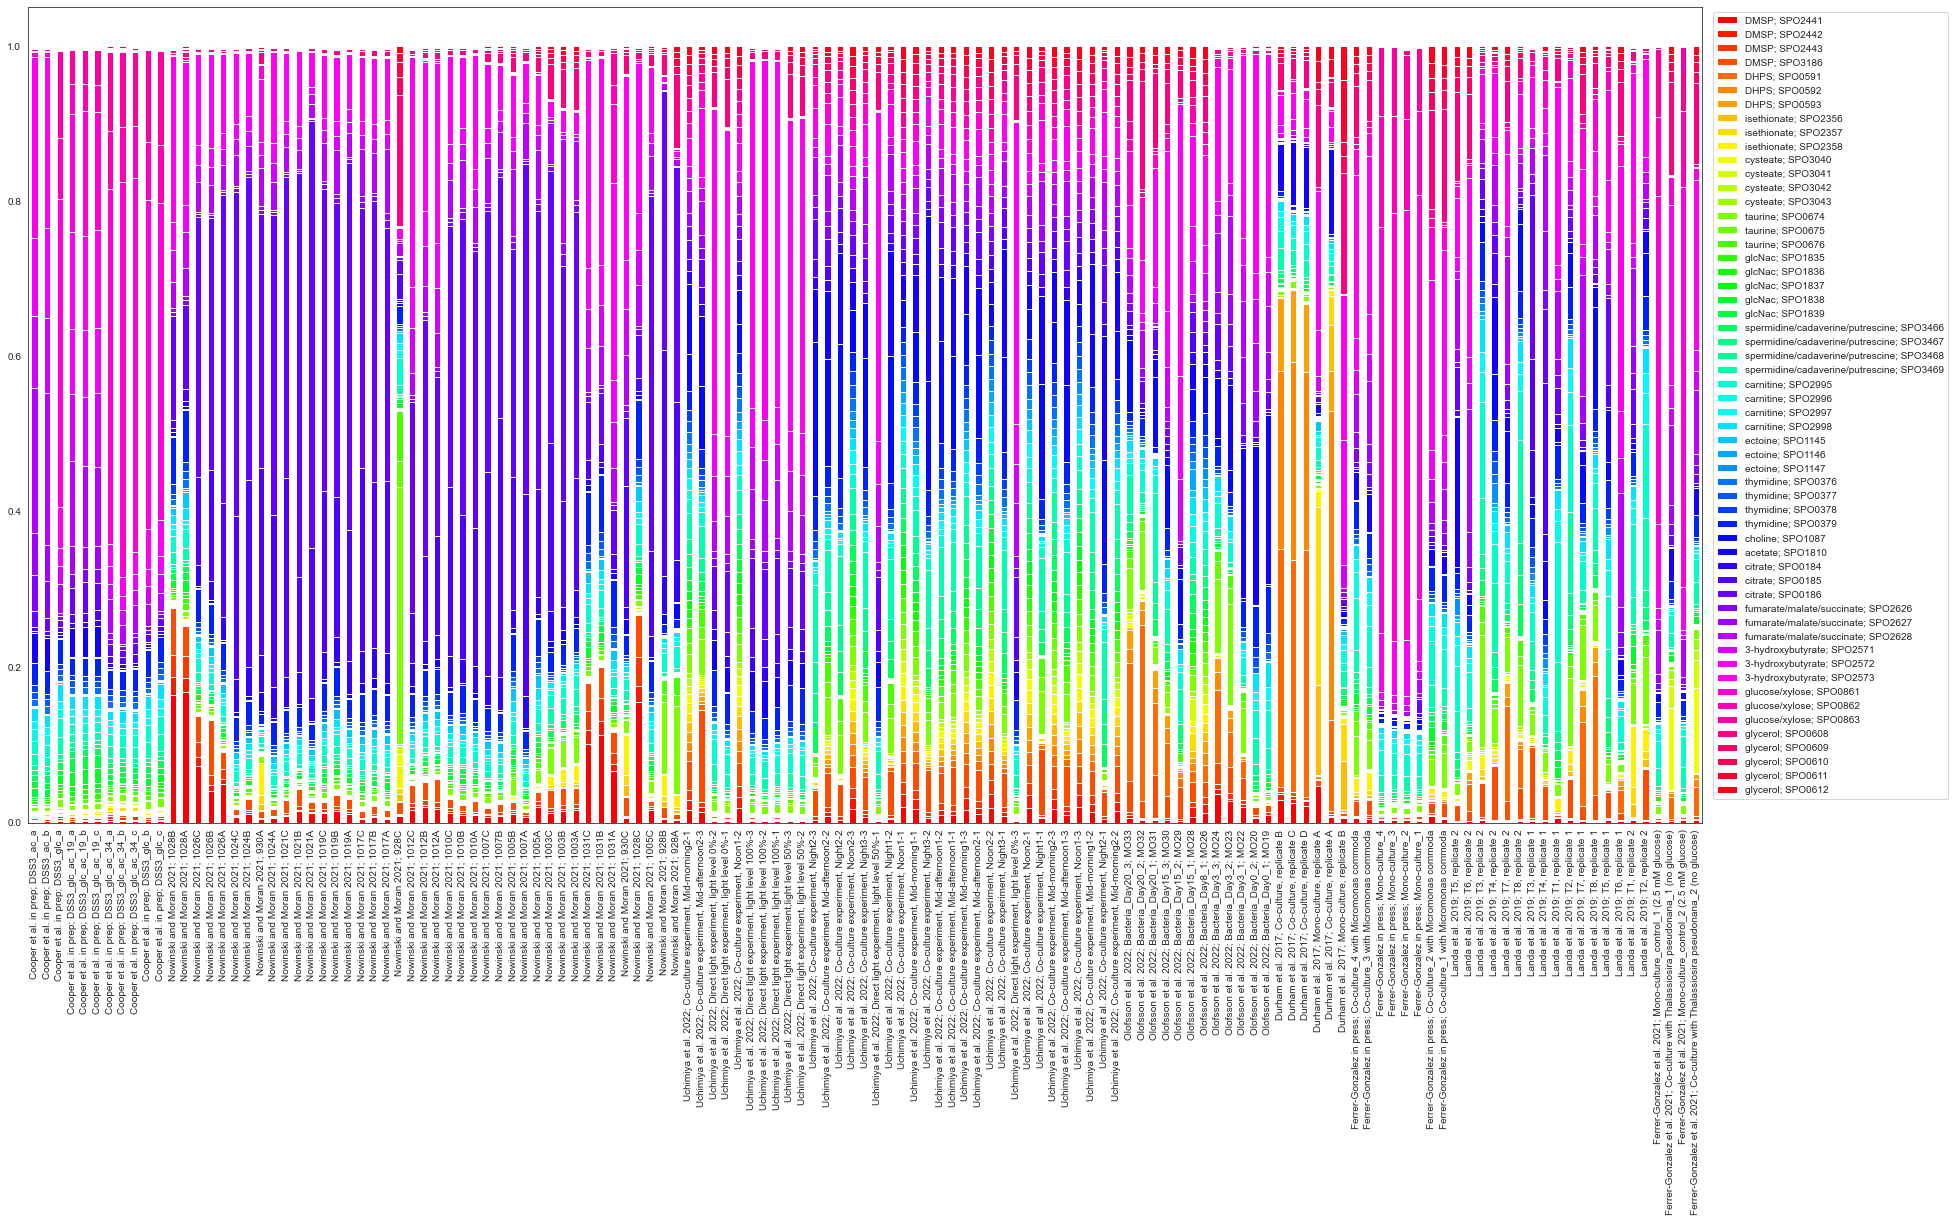

In [13]:
#First pass is to make a bar plot to see how the proportions vary from sample to sample
sns.set_style('white')
transpo_TPM_df.T.plot(kind='bar',stacked=True,figsize=(30,15),legend='reverse',colormap='hsv') #pandas' baked in bar plot method
plt.legend(loc=1,bbox_to_anchor=(1.15,1))

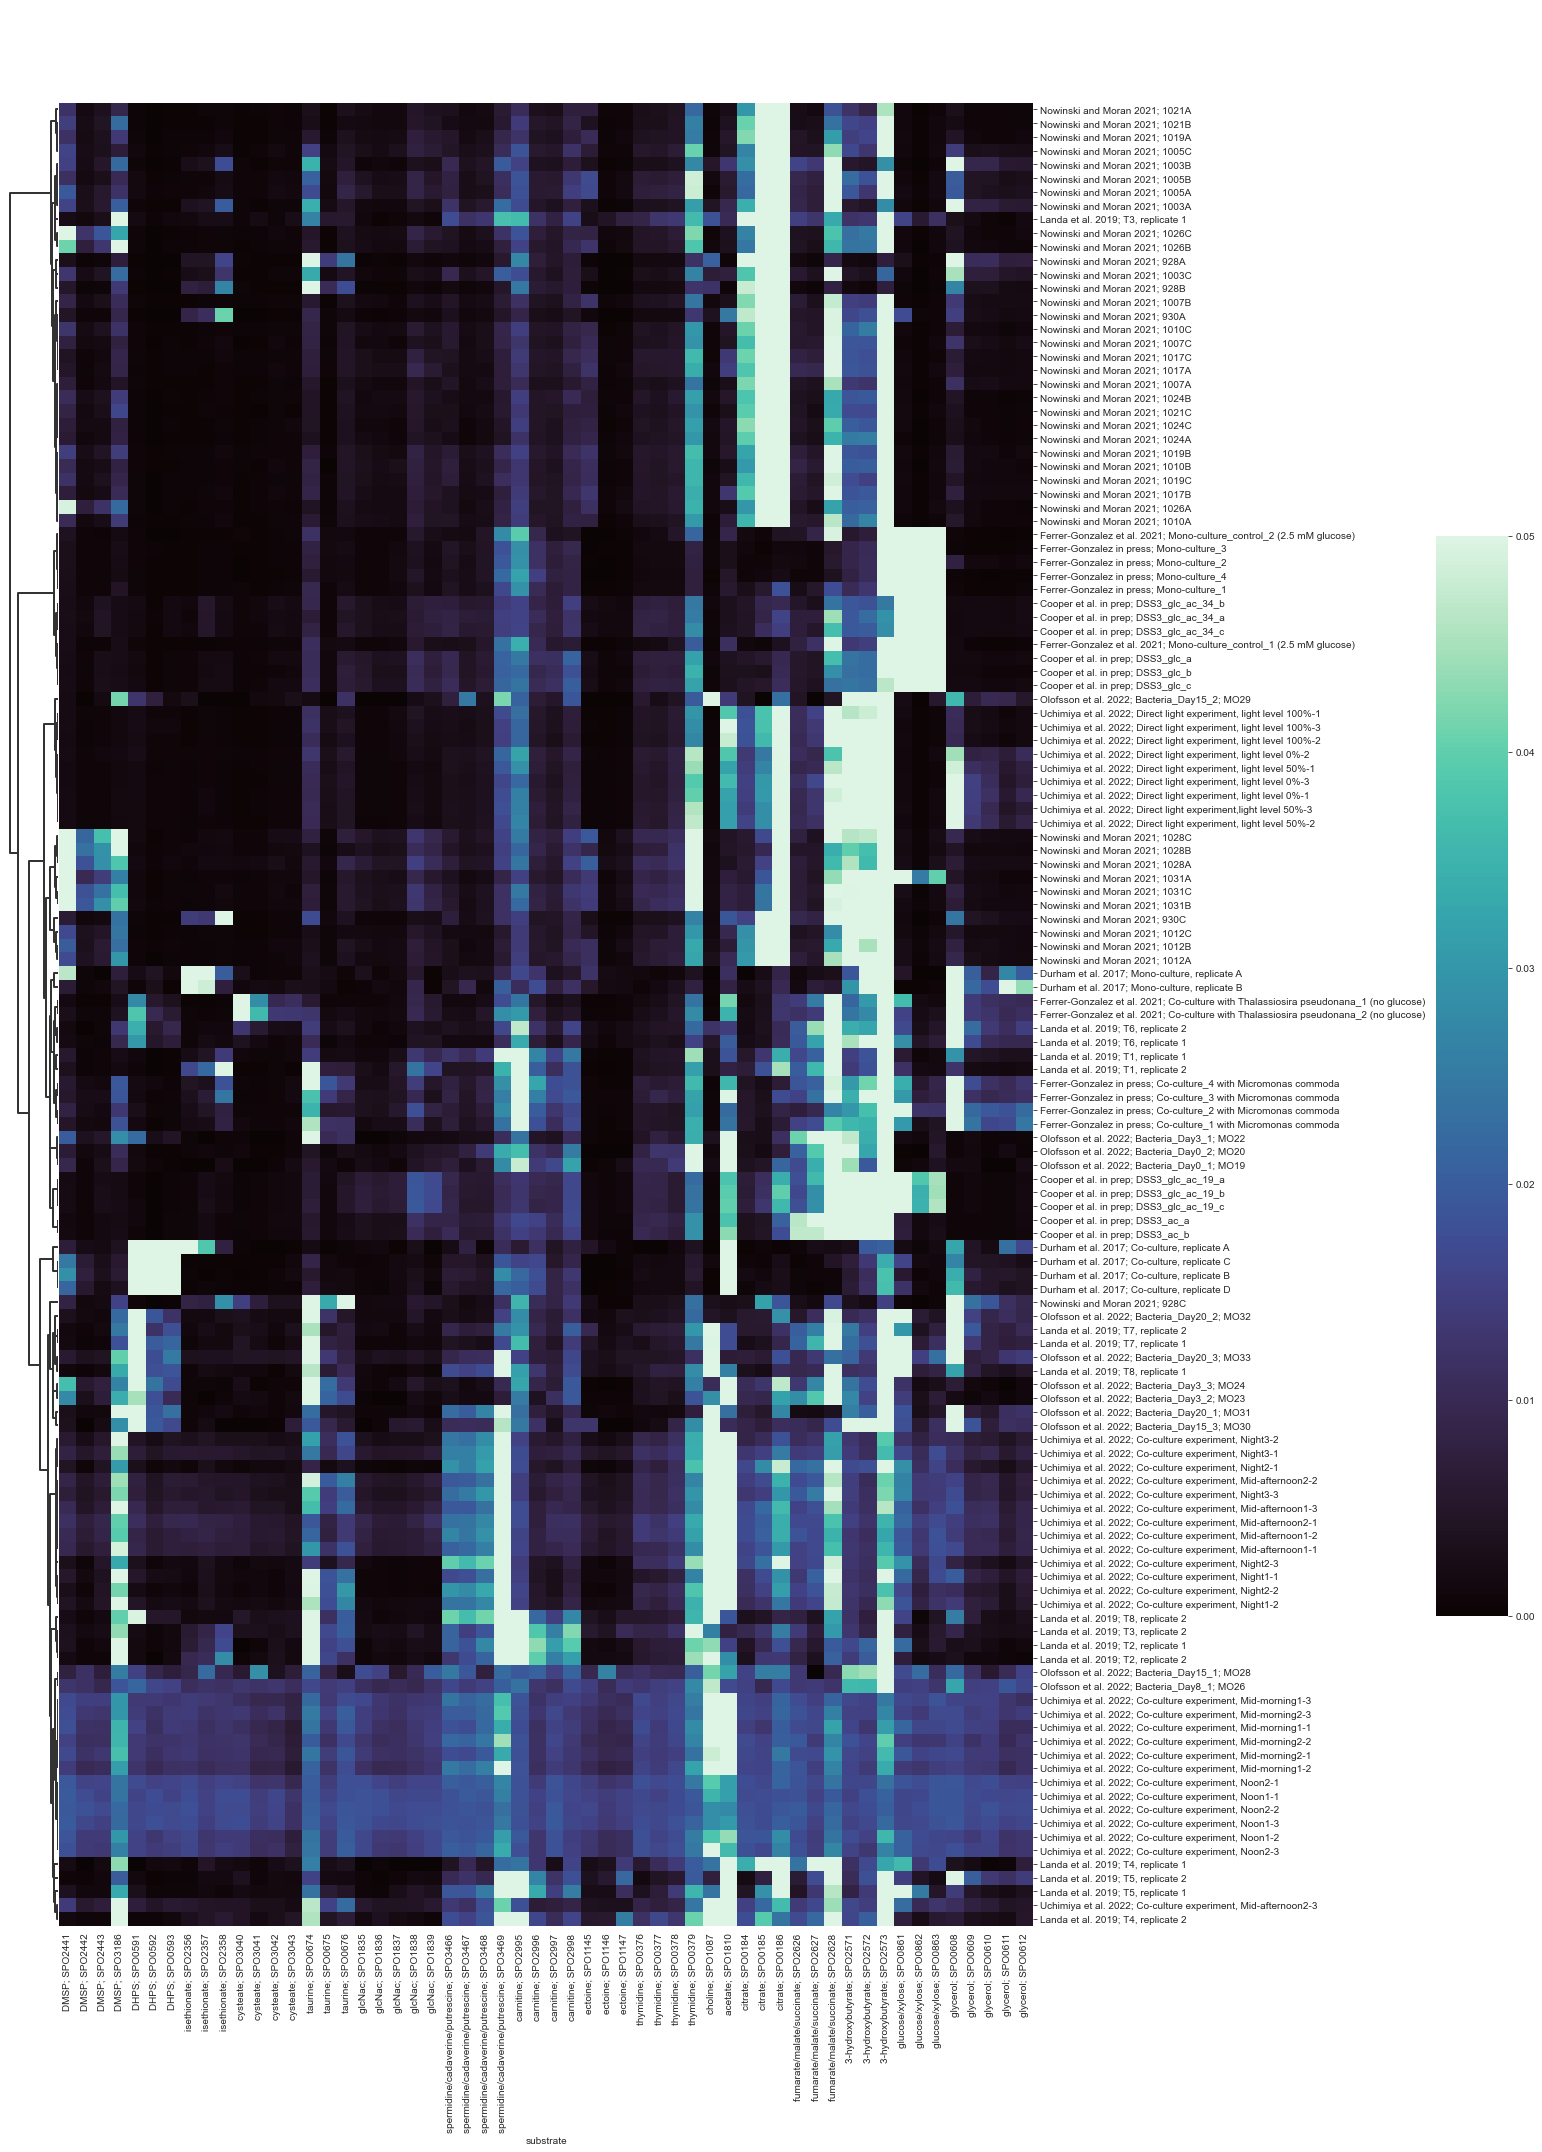

In [14]:
#Let's put it into a clustered heatmap, that'll be more interesting
sns.set_style('white')
sns.clustermap(transpo_TPM_df.T,xticklabels=True,yticklabels=True,vmax=0.05,col_cluster=False,
               method='ward',metric='euclidean',figsize=(20,30),cmap='mako',cbar_pos=(1,0.25,.05,.5),
              dendrogram_ratio=(.05,.05),tree_kws=dict(linewidths=2))

In [15]:
#Test for significant difference in SBP expression between diatom and dinoflagellate focused experiments

dinoflagellate_expts = ['Nowinski and Moran 2021; 1028B','Nowinski and Moran 2021; 1028A','Nowinski and Moran 2021; 1026C','Nowinski and Moran 2021; 1026B',
                        'Nowinski and Moran 2021; 1026A','Nowinski and Moran 2021; 1024C','Nowinski and Moran 2021; 1024B','Nowinski and Moran 2021; 930A',
                        'Nowinski and Moran 2021; 1024A','Nowinski and Moran 2021; 1021C','Nowinski and Moran 2021; 1021B','Nowinski and Moran 2021; 1021A',
                        'Nowinski and Moran 2021; 1019C','Nowinski and Moran 2021; 1019B','Nowinski and Moran 2021; 1019A','Nowinski and Moran 2021; 1017C',
                        'Nowinski and Moran 2021; 1017B','Nowinski and Moran 2021; 1017A','Nowinski and Moran 2021; 928C','Nowinski and Moran 2021; 1012C',
                        'Nowinski and Moran 2021; 1012B','Nowinski and Moran 2021; 1012A','Nowinski and Moran 2021; 1010C','Nowinski and Moran 2021; 1010B',
                        'Nowinski and Moran 2021; 1010A','Nowinski and Moran 2021; 1007C','Nowinski and Moran 2021; 1007B','Nowinski and Moran 2021; 1005B',
                        'Nowinski and Moran 2021; 1007A','Nowinski and Moran 2021; 1005A','Nowinski and Moran 2021; 1003C','Nowinski and Moran 2021; 1003B',
                        'Nowinski and Moran 2021; 1003A','Nowinski and Moran 2021; 1031C','Nowinski and Moran 2021; 1031B','Nowinski and Moran 2021; 1031A',
                        'Nowinski and Moran 2021; 930C','Nowinski and Moran 2021; 1028C','Nowinski and Moran 2021; 1005C','Nowinski and Moran 2021; 928B',
                        'Nowinski and Moran 2021; 928A',
                        'Landa et al. 2019; T2, replicate 1','Landa et al. 2019; T2, replicate 2']
diatom_expts = ['Landa et al. 2019; T7, replicate 1','Landa et al. 2019; T7, replicate 2',
                'Uchimiya et al. 2022; Co-culture experiment, Mid-morning2-1','Uchimiya et al. 2022; Co-culture experiment, Mid-afternoon2-3','Uchimiya et al. 2022; Direct light experiment, light level 0%-2',
                'Uchimiya et al. 2022; Direct light experiment, light level 0%-1','Uchimiya et al. 2022; Co-culture experiment, Noon1-2','Uchimiya et al. 2022; Direct light experiment, light level 100%-3','Uchimiya et al. 2022; Direct light experiment, light level 100%-2',
                'Uchimiya et al. 2022; Direct light experiment, light level 100%-1','Uchimiya et al. 2022; Direct light experiment,light level 50%-3','Uchimiya et al. 2022; Direct light experiment, light level 50%-2','Uchimiya et al. 2022; Co-culture experiment, Night2-3',
                'Uchimiya et al. 2022; Co-culture experiment, Mid-afternoon2-2','Uchimiya et al. 2022; Co-culture experiment, Night2-2','Uchimiya et al. 2022; Co-culture experiment, Noon2-3','Uchimiya et al. 2022; Co-culture experiment, Night3-3',
                'Uchimiya et al. 2022; Direct light experiment, light level 50%-1','Uchimiya et al. 2022; Co-culture experiment, Night1-2','Uchimiya et al. 2022; Co-culture experiment, Noon1-1','Uchimiya et al. 2022; Co-culture experiment, Mid-morning1-1',
                'Uchimiya et al. 2022; Co-culture experiment, Night3-2','Uchimiya et al. 2022; Co-culture experiment, Mid-afternoon1-2','Uchimiya et al. 2022; Co-culture experiment, Mid-afternoon1-1','Uchimiya et al. 2022; Co-culture experiment, Mid-morning1-3',
                'Uchimiya et al. 2022; Co-culture experiment, Mid-afternoon2-1','Uchimiya et al. 2022; Co-culture experiment, Noon2-2','Uchimiya et al. 2022; Co-culture experiment, Night3-1','Uchimiya et al. 2022; Direct light experiment, light level 0%-3',
                'Uchimiya et al. 2022; Co-culture experiment, Noon2-1','Uchimiya et al. 2022; Co-culture experiment, Night1-1','Uchimiya et al. 2022; Co-culture experiment, Mid-morning2-3','Uchimiya et al. 2022; Co-culture experiment, Mid-afternoon1-3',
                'Uchimiya et al. 2022; Co-culture experiment, Noon1-3','Uchimiya et al. 2022; Co-culture experiment, Mid-morning1-2','Uchimiya et al. 2022; Co-culture experiment, Night2-1',
                'Uchimiya et al. 2022; Co-culture experiment, Mid-morning2-2']

SBP_list = ['DMSP; SPO2441','DMSP; SPO3186','DHPS; SPO0591','isethionate; SPO2358','cysteate; SPO3043','taurine; SPO0674',#organic sulfur
            'glcNac; SPO1839','spermidine/cadaverine/putrescine; SPO3469','carnitine; SPO2995','ectoine; SPO1145','thymidine; SPO0379','choline; SPO1087', #organic nitrogen
            'acetate; SPO1810','citrate; SPO0186','fumarate/malate/succinate; SPO2628','3-hydroxybutyrate; SPO2573',#organic acids
            'glucose/xylose; SPO0861','glycerol; SPO0608'] #sugars

#this function applies a t-test for each gene to compare between dinflagellate and diatom-associated samples
def test_expression_diffs(gene,stats=False):
    vals_dino = []
    vals_diatom = []
    for expt in list(transpo_TPM_df.columns):
        val = transpo_TPM_df.loc[gene][expt]
        if expt in dinoflagellate_expts:
            vals_dino.append(val)
        elif expt in diatom_expts:
            vals_diatom.append(val)
    stat,p = scipy.stats.ttest_ind(vals_dino,vals_diatom)
    if p <= 0.05:
        if np.mean(vals_dino) > np.mean(vals_diatom):
            print(f'Expression of {gene} is greater for dinoflagellates (p = {p})')
        elif np.mean(vals_dino) < np.mean(vals_diatom):
            print(f'Expression of {gene} is greater for diatoms (p = {p})')
    else:
        print(f'No statistical difference for {gene}')
    if stats==True:
        return (stat,p)

In [16]:
for SBP in SBP_list:
    test_expression_diffs(SBP)

Expression of DMSP; SPO2441 is greater for dinoflagellates (p = 0.006556624845536885)
No statistical difference for DMSP; SPO3186
Expression of DHPS; SPO0591 is greater for diatoms (p = 0.0010158687646167684)
No statistical difference for isethionate; SPO2358
Expression of cysteate; SPO3043 is greater for diatoms (p = 5.074358533239664e-08)
No statistical difference for taurine; SPO0674
Expression of glcNac; SPO1839 is greater for diatoms (p = 0.005560286953201093)
Expression of spermidine/cadaverine/putrescine; SPO3469 is greater for diatoms (p = 1.0841772027536534e-07)
No statistical difference for carnitine; SPO2995
Expression of ectoine; SPO1145 is greater for dinoflagellates (p = 0.021969398148902194)
No statistical difference for thymidine; SPO0379
Expression of choline; SPO1087 is greater for diatoms (p = 2.5639159137507065e-10)
Expression of acetate; SPO1810 is greater for diatoms (p = 2.6469979709957053e-14)
Expression of citrate; SPO0186 is greater for dinoflagellates (p = 6.

This final plot shows interesting correlatory patterns of expression of a set of genes for transporters whose substrates have been confirmed. We see patterns between samples where similar mono-culture experiments cluster together, and we see groupings of co-cultures distinguished by which phytoplankton species *R. pomeroyi* is paired with. We can also see patterns of which substrates share similar expression patterns for their transporters. Choline and acetate are grouped tightly together in expression here, and we see similar patterns in citrate, 3-hydroxybutyrate, and glucose/xylose transporter expression. On a broad scale, we also see that studies overall tend to stay grouped together.

We have also added a brief statistical analysis that compares the mean expression of the substrate binding proteins (SBPs) of each transporter in studies either defined by either co-culture conditions, natural bloom conditions, or spent media from a culture of diatoms or dinoflagellates. This axis gives us the opportunity to understand which substrates are sought after by Rpom when it is in the presence of metabolites from either phytoplankter. 